## Cài đặt các thư viện cần thiết

In [1]:
# !pip install neattext
# !pip install wordcloud
# !pip install nltk

## Import các thư viện cần thiết

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
from nltk.corpus import stopwords
import re

import neattext as nt

## Đọc dữ liệu từ file

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
print('Train data shape:', train_df.shape)
print('Train columns:', train_df.columns)
print('Test data shape:', test_df.shape)
print('Test columns:', test_df.columns)

Train data shape: (17307, 3)
Train columns: Index(['essay_id', 'full_text', 'score'], dtype='object')
Test data shape: (3, 2)
Test columns: Index(['essay_id', 'full_text'], dtype='object')


## Tiền xử lý dữ liệu

In [8]:
print('Number of duplicated text on train data: ',train_df.duplicated(['full_text']).sum())
print('Number of duplicated text on test data: ',test_df.duplicated(['full_text']).sum())

Number of duplicated text on train data:  0
Number of duplicated text on test data:  0


In [11]:
train_df[train_df['full_text'].duplicated() == True].sort_values(by=['full_text'])

,essay_id,full_text,score


## Làm sạch cột full_text

In [12]:
def clean_text(text):
    text = re.sub(r"(?:\@)\S+", "", text) #Loại bỏ mention
    text = text.lower()
    docx = nt.TextFrame(text=text)
    docx.normalize()
    docx.remove_urls()
    docx.remove_emojis()
    docx.remove_emails()
    docx.remove_puncts()
    docx.remove_special_characters()
    docx.remove_numbers()
    docx.remove_stopwords()
    docx.fix_contractions()
    return docx.text

### Thực hiện áp dụng hàm clean_text() vào tập train và tập full_text.

In [13]:
train_df['full_text']=train_df['full_text'].apply(lambda x: clean_text(x))
test_df['full_text']=test_df['full_text'].apply(lambda x: clean_text(x))

### Bây giờ hãy nhìn xem các full_text trong tập train có dạng như thế nào.

In [14]:
train_df['full_text']

0        people car live thing dont know use car alot t...
1        scientist nasa discussing face mars explaining...
2        people wish technology seen movies best new pi...
3        heard venus planet oxygen earthquakes erupting...
4        dear state senatorthis letter argue favor keep...
                               ...                        
17302    story challenge exploing venus informative pie...
17303    technology changed lot ways live today nowaday...
17304    dont like sitting day great opportunity partic...
17305    challenge exporing venus author suggests study...
17306    venus worthy place study dangerous reaosn thei...
Name: full_text, Length: 17307, dtype: object

In [15]:
test_df['full_text']

0    people car live thing dont know use car alot t...
1    scientist nasa discussing face mars explaining...
2    people wish technology seen movies best new pi...
Name: full_text, dtype: object

In [16]:
print(train_df[train_df['full_text'] ==""])
print(test_df[test_df['full_text'] ==""])

Empty DataFrame
Columns: [essay_id, full_text, score]
Index: []
Empty DataFrame
Columns: [essay_id, full_text]
Index: []


# Khám phá cột text

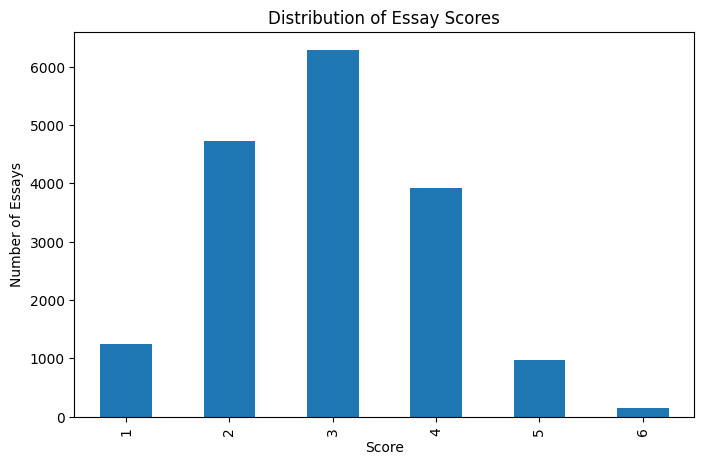

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
train_df['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Number of Essays')
plt.title('Distribution of Essay Scores')
plt.show()


In [19]:
train_df['essay_length'] = train_df['full_text'].apply(len)
essay_length_stats = train_df['essay_length'].describe()
print(essay_length_stats)

count    17307.000000
mean      1149.352170
std        516.224707
min        282.000000
25%        762.000000
50%       1058.000000
75%       1424.000000
max       5109.000000
Name: essay_length, dtype: float64


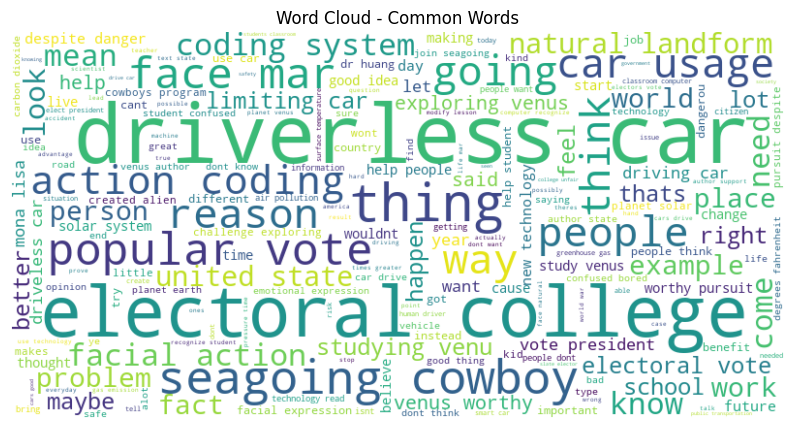

In [20]:
text_combined = ' '.join(train_df['full_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Common Words')
plt.show()

# Xuất kết quả của phần khám phá và tiền xử lý ra file.

In [21]:
train_df.to_csv('train_preprocessing.csv')
test_df.to_csv('test_preprocessing.csv')